Primeiro, importemos algumas bibliotecas úteis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier

Vamos repetir todo o processo de tratamento dos dados realizados no último notebook, assim poderemos focar na produção e comparação dos diferentes tipos de classificadores, marcamos de azul onde se inicia a análise nova.

Os 4 tipos de classificadores escolhidos serão: regressão logística, SVM, boosting e random forest. Vamos importá-los:

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

Vamos importar os dados da base adult:

In [3]:
treino_adult = pd.read_csv("/kaggle/input/adult-pmr3508/train_data.csv",
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

teste_adult = pd.read_csv("/kaggle/input/adult-pmr3508/test_data.csv",
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

Y_exemplo = pd.read_csv("/kaggle/input/adult-pmr3508/sample_submission.csv",
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

Vamos ver como são as base de dados:

In [4]:
treino_adult.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [5]:
treino_adult.shape


(32560, 16)

In [6]:
teste_adult.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,25,Private,120596,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,44,United-States
1,1,64,State-gov,152537,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
2,2,31,Private,100135,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
3,3,45,Private,189123,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States
4,4,64,Self-emp-inc,487751,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States


In [7]:
teste_adult.shape

(16280, 15)

Vamos produzir um histograma da variável idade, dessa forma podemos buscar por outliers ou analisar possíveis más distribuições de dados.

(array([2410., 3160., 2461., 3429., 3465., 2583., 3197., 2965., 1828.,
        2139., 1558., 1033.,  996.,  599.,  269.,  227.,  120.,   54.,
          20.,   47.]),
 array([17.  , 20.65, 24.3 , 27.95, 31.6 , 35.25, 38.9 , 42.55, 46.2 ,
        49.85, 53.5 , 57.15, 60.8 , 64.45, 68.1 , 71.75, 75.4 , 79.05,
        82.7 , 86.35, 90.  ]),
 <BarContainer object of 20 artists>)

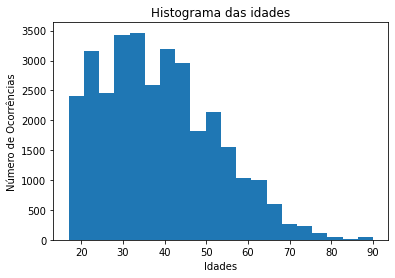

In [8]:
plt.xlabel('Idades')
plt.ylabel('Número de Ocorrências')
plt.title('Histograma das idades')
plt.hist(treino_adult["age"],20)

Não há nenhum dado absurdo, como uma idade de 150 ou negativa. Contudo, há maior incidência de menores idades, isso causará impacto nos resultados, pois alguns estudos correlacionam maior experiência no mercado de trabalho com maiores salários. A distribuição encontrada dialoga bem com a estrutura etária da população de países desenvolvidos nos anos 90 e parece correta.

Agora vamos analisar o número de anos de estudo e, novamente, procurar possíveis erros:

(array([   51.,   168.,   333.,   646.,   514.,   933.,  1175.,   433.,
        10501.,  7291.,  1382.,  1067.,  5354.,  1723.,   576.,   413.]),
 array([ 1.    ,  1.9375,  2.875 ,  3.8125,  4.75  ,  5.6875,  6.625 ,
         7.5625,  8.5   ,  9.4375, 10.375 , 11.3125, 12.25  , 13.1875,
        14.125 , 15.0625, 16.    ]),
 <BarContainer object of 16 artists>)

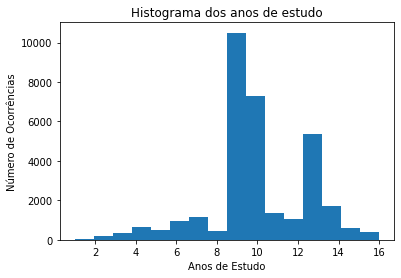

In [9]:
plt.xlabel('Anos de Estudo')
plt.ylabel('Número de Ocorrências')
plt.title('Histograma dos anos de estudo')
plt.hist(treino_adult["education.num"],16)

Vemos uma clara tendência a maiores anos de estudo, isso é esperado em países desenvolvidos, assim há bem maior número de pessoas com 9 ou mais anos de estudo.

Agora vamos analisar os dados concernentes a horas trabalhadas por semana, uma visão preliminar da tabela parece indicar maior tendência a 40 horas semanais.

(array([  205.,   531.,   645.,  1547.,  1015.,  1302.,  1635., 16099.,
         2442.,   677.,  3036.,   841.,  1519.,   277.,   365.,    83.,
          182.,    20.,    34.,   105.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ,
        54.9, 59.8, 64.7, 69.6, 74.5, 79.4, 84.3, 89.2, 94.1, 99. ]),
 <BarContainer object of 20 artists>)

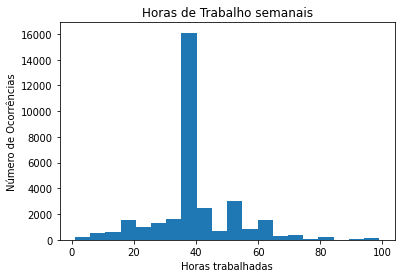

In [10]:
plt.xlabel('Horas trabalhadas')
plt.ylabel('Número de Ocorrências')
plt.title('Horas de Trabalho semanais')
plt.hist(treino_adult["hours.per.week"],20)

Existem alguns dados um pouco estranhos, com um indivíduo trabalhando quase 100 h semanais, vamos ver esse dado mais de perto.

In [11]:
max(treino_adult["hours.per.week"])

99

Apesar de estranho, esse dado não pode ser considerado um outlier, pois é, de fato, possível trabalhar 99 h semanais, dessa forma não retirarei tal dado.

Vamos passar a engenharia de dados. Primeiro com o país:

In [12]:
treino_adult["native.country"].value_counts()

United-States                 29169
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece                      

Precisamos tentar quantificar quanto seu país de origem influencia na sua renda. Podemos fazer uma divisão baseada em países parecidos aos Estados Unidos e países mais distintos, em relação à renda. Ou seja, unirei os dados relativos à United-States, Germany, Canada, England, Italy, Japan, Portugal, France, Ireland, Hong, Outlying-US, Scotland e Holand-Netherlands, aos quais atribuirei valor 1 e aos outros atribuirei valor 0, inclusive caso não se saiba o país de origem. A ideia seria dividir os países entre desenvolvidos e em desenvolvimento.

Primeiro façamos isso para a base de treino:

In [13]:
n=0
for x in treino_adult["native.country"]:
    if x in {'United-States', 'Germany', 'Canada', 'England', 'Italy', 'Japan', 'Portugal', 'France', 'Ireland', 'Hong','Outlying-US(Guam-USVI-etc)', 'Scotland','Holand-Netherlands'}:
        treino_adult['native.country'][n] = 1
    else:
        treino_adult['native.country'][n] = 0
    n=n+1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
treino_adult.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,1,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,1,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,1,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,1,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,0,>50K


A seguir façamos o mesmo processo para a base de teste:

In [15]:
n=0
for x in teste_adult["native.country"]:
    if x in {'United-States', 'Germany', 'Canada', 'England', 'Italy', 'Japan', 'Portugal', 'France', 'Ireland', 'Hong','Outlying-US(Guam-USVI-etc)', 'Scotland','Holand-Netherlands'}:
        teste_adult['native.country'][n] = 1
    else:
        teste_adult['native.country'][n] = 0
    n=n+1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
teste_adult.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,25,Private,120596,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,44,1
1,1,64,State-gov,152537,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,1
2,2,31,Private,100135,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,1
3,3,45,Private,189123,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,1
4,4,64,Self-emp-inc,487751,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,1


Vamos analisar as possibilidades da variável 'race':

In [17]:
treino_adult["race"].value_counts()

White                 27815
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

Agora analisemos a saída da variável 'sex':

In [18]:
treino_adult["sex"].value_counts()

Male      21789
Female    10771
Name: sex, dtype: int64

Vamos substituir os valores Male por 0 e Female por 1:

Primeiro na base de treino:

In [19]:
n=0
for x in treino_adult["sex"]:
    if x == 'Male':
        treino_adult["sex"][n] = 0
    else:
        treino_adult["sex"][n] = 1
    n=n+1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Agora na base de teste:

In [20]:
n=0
for x in teste_adult["sex"]:
    if x == 'Male':
        teste_adult["sex"][n] = 0
    else:
        teste_adult["sex"][n] = 1
    n=n+1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Vamos observar se está tudo correto nas bases:

In [21]:
treino_adult.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,0,0,0,44,1,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,0,0,0,40,1,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,0,0,0,42,1,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,1,0,0,40,1,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,0,5178,0,60,0,>50K


In [22]:
teste_adult.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,25,Private,120596,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,0,0,0,44,1
1,1,64,State-gov,152537,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,45,1
2,2,31,Private,100135,Masters,14,Divorced,Exec-managerial,Not-in-family,White,1,0,0,40,1
3,3,45,Private,189123,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,0,0,0,40,1
4,4,64,Self-emp-inc,487751,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,50,1


Tudo parece certo. Agora vamos nos preocupar com a distribuição em relação ao estado civil:

In [23]:
treino_adult['marital.status'].value_counts()

Married-civ-spouse       14976
Never-married            10682
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

Usando o bom-senso tentarei trabalhar com os dados de estado civil. Podemos começar pensando que os estados divorciado e separado são em algum nível equivalentes. O divórcio pode ter impacto na renda, na forma de algum tipo de pensão, ou algo do gênero. Podemos pensar no fato que pessoas casadas tem maior tendência a ter filhos, e dado que esses causam um gasto considerável, há maior pressão por rendas maiores. Dessa forma atribuirei valor 1 para os estados 'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse', valor 0.5 para os estado 'Never-married' e valor 0 para todos outros estados. Pode parecer estranhos juntar divorciado e viúvo, por exemplo. No entanto, a maioria dos viúvos é formada por idosos, que tem menor renda, que é o que suponho ocorrer no caso de divórcio ou separação.

In [24]:
n=0
for x in treino_adult["marital.status"]:
    if x in {'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'}:
        treino_adult["marital.status"][n] = 1
    elif x == 'Never-married':
        treino_adult["marital.status"][n] = 0.5
    else:
        treino_adult["marital.status"][n] = 0
    n=n+1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
n=0
for x in teste_adult["marital.status"]:
    if x in {'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'}:
        teste_adult["marital.status"][n] = 1
    elif x == 'Never-married':
        teste_adult["marital.status"][n] = 0.5
    else:
        teste_adult["marital.status"][n] = 0
    n=n+1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Vamos observar se o processo foi correto:

In [26]:
treino_adult.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,0,Exec-managerial,Own-child,White,0,0,0,44,1,<=50K
1,16281,58,Local-gov,310085,10th,6,1,Transport-moving,Husband,White,0,0,0,40,1,<=50K
2,16282,25,Private,146117,Some-college,10,0.5,Machine-op-inspct,Not-in-family,White,0,0,0,42,1,<=50K
3,16283,24,Private,138938,Some-college,10,0,Adm-clerical,Not-in-family,White,1,0,0,40,1,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,1,Transport-moving,Husband,White,0,5178,0,60,0,>50K


In [27]:
teste_adult.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,25,Private,120596,Bachelors,13,0.5,Prof-specialty,Not-in-family,White,0,0,0,44,1
1,1,64,State-gov,152537,Bachelors,13,1,Exec-managerial,Husband,White,0,0,0,45,1
2,2,31,Private,100135,Masters,14,0,Exec-managerial,Not-in-family,White,1,0,0,40,1
3,3,45,Private,189123,HS-grad,9,0.5,Machine-op-inspct,Own-child,White,0,0,0,40,1
4,4,64,Self-emp-inc,487751,Bachelors,13,1,Exec-managerial,Husband,White,0,0,0,50,1


Parece tudo certo.

Vamos analisar os dados relacionados a feature 'Workclass'. Primeiro vejamos todas possibilidades:

In [28]:
teste_adult['workclass'].value_counts()

Private             11209
Self-emp-not-inc     1321
Local-gov            1043
State-gov             683
Self-emp-inc          579
Federal-gov           472
Without-pay             7
Never-worked            3
Name: workclass, dtype: int64

Claramente os valores 'without-pay' e 'Never-worked' terão grande impacto na renda anual do indivíduo, vamos agrupá-las com o valor -1, pois é de se esperar que tais condições tenham um impacto enorme na renda do indivíduo. Vamos unir os servidores públicos no valor 0 e os privados no valor 0.5, ou seja, atribuiremos 0 para 'Local-gov', 'State-gov' e 'Federal-gov', por fim, vamos atribuir aos empreendedores o valor 1. 

In [29]:
n=0
for x in teste_adult["workclass"]:
    if x in {'Without-pay', 'Never-worked' }:
        teste_adult["workclass"][n] = -1
    elif x in {'Local-gov', 'State-gov', 'Federal-gov'}:
        teste_adult["workclass"][n] = 0
    elif x == 'Private':
        teste_adult["workclass"][n] = 0.5
    else:
        teste_adult["workclass"][n] = 1
    n=n+1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launc

In [30]:
n=0
for x in treino_adult["workclass"]:
    if x in {'Without-pay', 'Never-worked' }:
        treino_adult["workclass"][n] = -1
    elif x in {'Local-gov', 'State-gov', 'Federal-gov'}:
        treino_adult["workclass"][n] = 0
    elif x == 'Private':
        treino_adult["workclass"][n] = 0.5
    else:
        treino_adult["workclass"][n] = 1
    n=n+1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launc

Novamente analisando a saída:

In [31]:
treino_adult.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,0.5,204991,Some-college,10,0,Exec-managerial,Own-child,White,0,0,0,44,1,<=50K
1,16281,58,0,310085,10th,6,1,Transport-moving,Husband,White,0,0,0,40,1,<=50K
2,16282,25,0.5,146117,Some-college,10,0.5,Machine-op-inspct,Not-in-family,White,0,0,0,42,1,<=50K
3,16283,24,0.5,138938,Some-college,10,0,Adm-clerical,Not-in-family,White,1,0,0,40,1,<=50K
4,16284,57,1,258883,HS-grad,9,1,Transport-moving,Husband,White,0,5178,0,60,0,>50K


In [32]:
teste_adult.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,25,0.5,120596,Bachelors,13,0.5,Prof-specialty,Not-in-family,White,0,0,0,44,1
1,1,64,0,152537,Bachelors,13,1,Exec-managerial,Husband,White,0,0,0,45,1
2,2,31,0.5,100135,Masters,14,0,Exec-managerial,Not-in-family,White,1,0,0,40,1
3,3,45,0.5,189123,HS-grad,9,0.5,Machine-op-inspct,Own-child,White,0,0,0,40,1
4,4,64,1,487751,Bachelors,13,1,Exec-managerial,Husband,White,0,0,0,50,1


Vamos analisar a feature 'relationship':

In [33]:
treino_adult['relationship'].value_counts()

Husband           13193
Not-in-family      8304
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

A questão de se a relação familiar impacta a renda é boa. A princípio não utilizarei esses dados, porque não consigo pensar em boas explicações para tanto.

In [34]:
treino_adult['occupation'].value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3769
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

A ocupação é claramente muito relevante para a renda, mas para conseguirmos usar essa feature para análises preditivas, precisariamos de dados correlacionando essas profissões e a renda obtida em cada um delas, como a proposta do trabalho é não utilizar dados externos, não usarei essa variável na análise.

Vamos analisar a distribuição das variáveis de ganho e perda de capital através de histogramas:

(array([3.179e+04, 5.170e+02, 8.700e+01, 5.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.590e+02]),
 array([    0. ,  9999.9, 19999.8, 29999.7, 39999.6, 49999.5, 59999.4,
        69999.3, 79999.2, 89999.1, 99999. ]),
 <BarContainer object of 10 artists>)

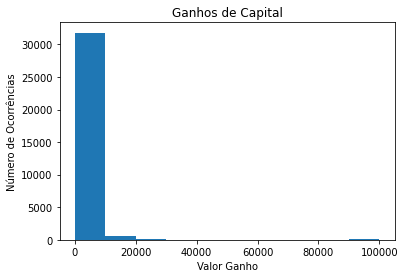

In [35]:
plt.xlabel('Valor Ganho')
plt.ylabel('Número de Ocorrências')
plt.title( 'Ganhos de Capital')
plt.hist(treino_adult["capital.gain"],10)

(array([3.1052e+04, 1.7000e+01, 2.1000e+01, 4.6100e+02, 7.7900e+02,
        2.0700e+02, 1.4000e+01, 0.0000e+00, 6.0000e+00, 3.0000e+00]),
 array([   0. ,  435.6,  871.2, 1306.8, 1742.4, 2178. , 2613.6, 3049.2,
        3484.8, 3920.4, 4356. ]),
 <BarContainer object of 10 artists>)

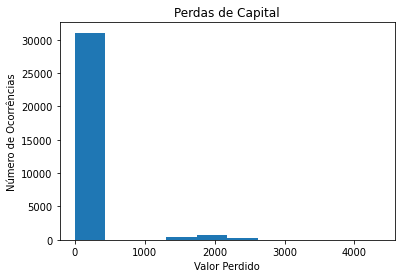

In [36]:
plt.xlabel('Valor Perdido')
plt.ylabel('Número de Ocorrências')
plt.title( 'Perdas de Capital')
plt.hist(treino_adult["capital.loss"],10)

São pouquíssimos dados relevantes sobre ganhos e perdas de capital, dessa forma não utilizarei esses dados na análise, pois só pela normalização, pessoas que tiveram ganhos próximos a 10000 terão um efeito muito pequeno, por exemplo.

Para a variável "Race" criaremos novas colunas com as saídas possíveis, usaremos o processo de one-hot encoding.

In [37]:
R = pd.get_dummies(treino_adult['race'])
G = pd.get_dummies(teste_adult['race'])

In [38]:
treino_adult = pd.concat([treino_adult, R], axis=1).reindex(treino_adult.index)
teste_adult = pd.concat([teste_adult, G], axis=1).reindex(teste_adult.index)

In [39]:
teste_adult

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,0,25,0.5,120596,Bachelors,13,0.5,Prof-specialty,Not-in-family,White,0,0,0,44,1,0,0,0,0,1
1,1,64,0,152537,Bachelors,13,1,Exec-managerial,Husband,White,0,0,0,45,1,0,0,0,0,1
2,2,31,0.5,100135,Masters,14,0,Exec-managerial,Not-in-family,White,1,0,0,40,1,0,0,0,0,1
3,3,45,0.5,189123,HS-grad,9,0.5,Machine-op-inspct,Own-child,White,0,0,0,40,1,0,0,0,0,1
4,4,64,1,487751,Bachelors,13,1,Exec-managerial,Husband,White,0,0,0,50,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,16275,40,0.5,168113,HS-grad,9,1,Craft-repair,Husband,White,0,0,0,40,1,0,0,0,0,1
16276,16276,30,0,327203,HS-grad,9,1,Other-service,Husband,White,0,0,0,40,1,0,0,0,0,1
16277,16277,25,0.5,116358,HS-grad,9,0.5,Adm-clerical,Own-child,Asian-Pac-Islander,0,0,0,40,0,0,1,0,0,0
16278,16278,60,0.5,39263,Masters,14,0.5,Exec-managerial,Not-in-family,White,1,3325,0,35,1,0,0,0,0,1


In [40]:
treino_adult

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,...,capital.gain,capital.loss,hours.per.week,native.country,income,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,16280,34,0.5,204991,Some-college,10,0,Exec-managerial,Own-child,White,...,0,0,44,1,<=50K,0,0,0,0,1
1,16281,58,0,310085,10th,6,1,Transport-moving,Husband,White,...,0,0,40,1,<=50K,0,0,0,0,1
2,16282,25,0.5,146117,Some-college,10,0.5,Machine-op-inspct,Not-in-family,White,...,0,0,42,1,<=50K,0,0,0,0,1
3,16283,24,0.5,138938,Some-college,10,0,Adm-clerical,Not-in-family,White,...,0,0,40,1,<=50K,0,0,0,0,1
4,16284,57,1,258883,HS-grad,9,1,Transport-moving,Husband,White,...,5178,0,60,0,>50K,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,48835,42,0.5,384236,Masters,14,1,Prof-specialty,Husband,White,...,7688,0,40,1,>50K,0,0,0,0,1
32556,48836,23,0.5,129042,HS-grad,9,0.5,Machine-op-inspct,Unmarried,Black,...,0,0,40,1,<=50K,0,0,1,0,0
32557,48837,30,0.5,195488,HS-grad,9,0.5,Priv-house-serv,Own-child,White,...,0,0,40,0,<=50K,0,0,0,0,1
32558,48838,18,0.5,27620,HS-grad,9,0.5,Adm-clerical,Not-in-family,White,...,0,0,25,1,<=50K,0,0,0,0,1


O processo deu certo.

Agora vamos nos preocupar com o nível educacional. Contudo, podemos notar que o grau de educação e o número de anos de estudo são variáveis que tem grande correlação, dessa forma não irei usar a coluna "Education" e ficarei apenas com a coluna "Education-Num".

In [41]:
teste_adult.drop('education', axis=1, inplace=True)
treino_adult.drop('education', axis=1, inplace=True)



Como já lidamos com a variável race, podemos tirá-la das bases de dados:

In [42]:
teste_adult.drop('race', axis=1, inplace=True)
treino_adult.drop('race', axis=1, inplace=True)

In [43]:
treino_adult

,Id,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,native.country,income,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,16280,34,0.5,204991,10,0,Exec-managerial,Own-child,0,0,0,44,1,<=50K,0,0,0,0,1
1,16281,58,0,310085,6,1,Transport-moving,Husband,0,0,0,40,1,<=50K,0,0,0,0,1
2,16282,25,0.5,146117,10,0.5,Machine-op-inspct,Not-in-family,0,0,0,42,1,<=50K,0,0,0,0,1
3,16283,24,0.5,138938,10,0,Adm-clerical,Not-in-family,1,0,0,40,1,<=50K,0,0,0,0,1
4,16284,57,1,258883,9,1,Transport-moving,Husband,0,5178,0,60,0,>50K,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,48835,42,0.5,384236,14,1,Prof-specialty,Husband,0,7688,0,40,1,>50K,0,0,0,0,1
32556,48836,23,0.5,129042,9,0.5,Machine-op-inspct,Unmarried,1,0,0,40,1,<=50K,0,0,1,0,0
32557,48837,30,0.5,195488,9,0.5,Priv-house-serv,Own-child,1,0,0,40,0,<=50K,0,0,0,0,1
32558,48838,18,0.5,27620,9,0.5,Adm-clerical,Not-in-family,1,0,0,25,1,<=50K,0,0,0,0,1


In [44]:
teste_adult

,Id,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,native.country,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,0,25,0.5,120596,13,0.5,Prof-specialty,Not-in-family,0,0,0,44,1,0,0,0,0,1
1,1,64,0,152537,13,1,Exec-managerial,Husband,0,0,0,45,1,0,0,0,0,1
2,2,31,0.5,100135,14,0,Exec-managerial,Not-in-family,1,0,0,40,1,0,0,0,0,1
3,3,45,0.5,189123,9,0.5,Machine-op-inspct,Own-child,0,0,0,40,1,0,0,0,0,1
4,4,64,1,487751,13,1,Exec-managerial,Husband,0,0,0,50,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,16275,40,0.5,168113,9,1,Craft-repair,Husband,0,0,0,40,1,0,0,0,0,1
16276,16276,30,0,327203,9,1,Other-service,Husband,0,0,0,40,1,0,0,0,0,1
16277,16277,25,0.5,116358,9,0.5,Adm-clerical,Own-child,0,0,0,40,0,0,1,0,0,0
16278,16278,60,0.5,39263,14,0.5,Exec-managerial,Not-in-family,1,3325,0,35,1,0,0,0,0,1


Passemos a normalizar os dados, primeiro da base de teste:

In [45]:
teste_adult['age'] = (teste_adult['age'] - min(teste_adult['age'])) / (max(teste_adult['age']) - min(teste_adult['age']))
teste_adult['education.num'] = (teste_adult['education.num'] - min(teste_adult['education.num'])) / (max(teste_adult['education.num']) - min(teste_adult['education.num']))
teste_adult['fnlwgt'] = (teste_adult['fnlwgt'] - min(teste_adult['fnlwgt'])) / (max(teste_adult['fnlwgt']) - min(teste_adult['fnlwgt']))
teste_adult['hours.per.week'] = (teste_adult['hours.per.week'] - min(teste_adult['hours.per.week'])) / (max(teste_adult['hours.per.week']) - min(teste_adult['hours.per.week']))


Depois da base de treino:

In [46]:
treino_adult['age'] = (treino_adult['age'] - min(treino_adult['age'])) / (max(treino_adult['age']) - min(treino_adult['age']))
treino_adult['education.num'] = (treino_adult['education.num'] - min(treino_adult['education.num'])) / (max(treino_adult['education.num']) - min(treino_adult['education.num']))
treino_adult['fnlwgt'] = (treino_adult['fnlwgt'] - min(treino_adult['fnlwgt'])) / (max(treino_adult['fnlwgt']) - min(treino_adult['fnlwgt']))
treino_adult['hours.per.week'] = (treino_adult['hours.per.week'] - min(treino_adult['hours.per.week'])) / (max(treino_adult['hours.per.week']) - min(treino_adult['hours.per.week']))


In [47]:
teste_adult

,Id,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week,native.country,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,0,0.109589,0.5,0.072519,0.800000,0.5,Prof-specialty,Not-in-family,0,0,0,0.438776,1,0,0,0,0,1
1,1,0.643836,0,0.094146,0.800000,1,Exec-managerial,Husband,0,0,0,0.448980,1,0,0,0,0,1
2,2,0.191781,0.5,0.058665,0.866667,0,Exec-managerial,Not-in-family,1,0,0,0.397959,1,0,0,0,0,1
3,3,0.383562,0.5,0.118918,0.533333,0.5,Machine-op-inspct,Own-child,0,0,0,0.397959,1,0,0,0,0,1
4,4,0.643836,1,0.321116,0.800000,1,Exec-managerial,Husband,0,0,0,0.500000,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,16275,0.315068,0.5,0.104692,0.533333,1,Craft-repair,Husband,0,0,0,0.397959,1,0,0,0,0,1
16276,16276,0.178082,0,0.212411,0.533333,1,Other-service,Husband,0,0,0,0.397959,1,0,0,0,0,1
16277,16277,0.109589,0.5,0.069650,0.533333,0.5,Adm-clerical,Own-child,0,0,0,0.397959,0,0,1,0,0,0
16278,16278,0.589041,0.5,0.017449,0.866667,0.5,Exec-managerial,Not-in-family,1,3325,0,0.346939,1,0,0,0,0,1


Vamos excluir as colunas que não usaremos ou que já tratamos:

In [48]:
teste_adult.drop('occupation', axis=1, inplace=True)
teste_adult.drop('relationship', axis=1, inplace=True)
teste_adult.drop('capital.gain', axis=1, inplace=True)
teste_adult.drop('capital.loss', axis=1, inplace=True)
teste_adult.drop('Id', axis=1, inplace = True)

treino_adult.drop('occupation', axis=1, inplace=True)
treino_adult.drop('relationship', axis=1, inplace=True)
treino_adult.drop('capital.gain', axis=1, inplace=True)
treino_adult.drop('capital.loss', axis=1, inplace=True)
treino_adult.drop('Id', axis=1, inplace = True)


In [49]:
treino_adult

,age,workclass,fnlwgt,education.num,marital.status,sex,hours.per.week,native.country,income,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,0.232877,0.5,0.130877,0.600000,0,0,0.438776,1,<=50K,0,0,0,0,1
1,0.561644,0,0.202252,0.333333,1,0,0.397959,1,<=50K,0,0,0,0,1
2,0.109589,0.5,0.090893,0.600000,0.5,0,0.418367,1,<=50K,0,0,0,0,1
3,0.095890,0.5,0.086017,0.600000,0,1,0.397959,1,<=50K,0,0,0,0,1
4,0.547945,1,0.167478,0.533333,1,0,0.602041,0,>50K,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,0.342466,0.5,0.252612,0.866667,1,0,0.397959,1,>50K,0,0,0,0,1
32556,0.082192,0.5,0.079296,0.533333,0.5,1,0.397959,1,<=50K,0,0,1,0,0
32557,0.178082,0.5,0.124423,0.533333,0.5,1,0.397959,0,<=50K,0,0,0,0,1
32558,0.013699,0.5,0.010415,0.533333,0.5,1,0.244898,1,<=50K,0,0,0,0,1


In [50]:
teste_adult

,age,workclass,fnlwgt,education.num,marital.status,sex,hours.per.week,native.country,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,0.109589,0.5,0.072519,0.800000,0.5,0,0.438776,1,0,0,0,0,1
1,0.643836,0,0.094146,0.800000,1,0,0.448980,1,0,0,0,0,1
2,0.191781,0.5,0.058665,0.866667,0,1,0.397959,1,0,0,0,0,1
3,0.383562,0.5,0.118918,0.533333,0.5,0,0.397959,1,0,0,0,0,1
4,0.643836,1,0.321116,0.800000,1,0,0.500000,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,0.315068,0.5,0.104692,0.533333,1,0,0.397959,1,0,0,0,0,1
16276,0.178082,0,0.212411,0.533333,1,0,0.397959,1,0,0,0,0,1
16277,0.109589,0.5,0.069650,0.533333,0.5,0,0.397959,0,0,1,0,0,0
16278,0.589041,0.5,0.017449,0.866667,0.5,1,0.346939,1,0,0,0,0,1


Vamos salvar a variável resposta da base de treino:

In [51]:
Y_treino = treino_adult['income']

In [52]:
Y_treino

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4         >50K
         ...  
32555     >50K
32556    <=50K
32557    <=50K
32558    <=50K
32559    <=50K
Name: income, Length: 32560, dtype: object

Vamos retirar a variável income da base de treino:

In [53]:
treino_adult.drop('income', axis=1, inplace=True)

In [54]:
treino_adult.shape

(32560, 13)

In [55]:
teste_adult.shape

(16280, 13)

In [56]:
teste_adult

,age,workclass,fnlwgt,education.num,marital.status,sex,hours.per.week,native.country,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,0.109589,0.5,0.072519,0.800000,0.5,0,0.438776,1,0,0,0,0,1
1,0.643836,0,0.094146,0.800000,1,0,0.448980,1,0,0,0,0,1
2,0.191781,0.5,0.058665,0.866667,0,1,0.397959,1,0,0,0,0,1
3,0.383562,0.5,0.118918,0.533333,0.5,0,0.397959,1,0,0,0,0,1
4,0.643836,1,0.321116,0.800000,1,0,0.500000,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,0.315068,0.5,0.104692,0.533333,1,0,0.397959,1,0,0,0,0,1
16276,0.178082,0,0.212411,0.533333,1,0,0.397959,1,0,0,0,0,1
16277,0.109589,0.5,0.069650,0.533333,0.5,0,0.397959,0,0,1,0,0,0
16278,0.589041,0.5,0.017449,0.866667,0.5,1,0.346939,1,0,0,0,0,1


In [57]:
teste_adult.drop('native.country', axis=1, inplace = True)
treino_adult.drop('native.country', axis=1, inplace = True)

# Análise dos Classificadores:

Em todo caso, na validação cruzada para seleção de parâmetros, usaremos 5 folds, a seguir, quando formos comparar classificadores diferentes, usaremos 10 folds, isso porque o custo computacional na seleção de parâmetros é muito alto, dessa forma, usando menos folds nesse momento, conseguiremos um algoritmo bem mais rápido.

Vamos começar pela regressão logística, nesse caso, vamos considerar como parâmetro apenas o fator de normalização C, vamos variá-lo no conjunto Y:

In [58]:
Y=[1,2,4,8]
scoreslogistic = []
for y in Y:    
    scoreslogistic.append(cross_val_score(LogisticRegression(random_state=0, C=y), treino_adult, Y_treino, cv=5))

Vamos salvar os resultados da validação cruzada na lista Mlogistic:

In [59]:
Mlogistic=[]
for j in scoreslogistic:
    Mlogistic.append(mean(j))

In [60]:
Mlogistic

[0.8161855036855037, 0.8160012285012285, 0.815970515970516, 0.8161855036855037]

Podemos ver que, inicialmente, à medida que aumentamos C, a eficiência do algoritmo nos dados de treino diminui, contudo, esse processo se reverte para C=8, em que a taxa de acerto é maior se comparada ao valor de C=4.

Vamos analisar o valor com maior taxa de acerto:

In [61]:
n=0
for x in range(1,len(Mlogistic)):
    if Mlogistic[x] > Mlogistic[n]:
        n = x

In [62]:
n

0

Que corresponde a C = 1, portanto esse parâmetro que utilizaremos para calcular a taxa de acerto em relação a toda base de dados.

Vamos criar o classificador usando SVM:

Há um hiperparâmetro e uma escolha bastante importante, esses são, respectivamente, o valor de C, que ditará como será a soft margin e é chamado de parâmetro de normalização e como será o kernel utilizado, vamos fazer alguns testes com validação cruzada.

As opções de Kernel que usaremos são:

In [63]:
KERNEL = ['linear', 'poly', 'rbf']

Vamos variar C de 1 até 8 dobrando seu valor a cada elemento da lista, esses valores usaremos para fazer a validação cruzada. Pode-se questionar nossas escolhas, contudo, o fato é que o tempo de execução do algoritmo é bastante elevado, por isso temos que limitar o número de parâmetros analisados.

In [64]:
V = [1,2,4,8]

In [65]:
h=0
print('{0:>16} | {1:>16} | {2:>16}'.format('Interação', 'Valor de C', 'Kernel'))
scores = []
for x in KERNEL:
    for y in V:
        scores.append(cross_val_score(SVC(C = y, kernel = x), treino_adult, Y_treino, cv=5))
        if x == 'poly':
            m = 'polinomial'
        elif x == 'rbf':
            m = 'radial basis function'
        else:
            m = x
        print('{0:>16} | {1:>16} | {2:>16}'.format(h, y, m))
        h = h+1

       Interação |       Valor de C |           Kernel
               0 |                1 |           linear
               1 |                2 |           linear
               2 |                4 |           linear
               3 |                8 |           linear
               4 |                1 |       polinomial
               5 |                2 |       polinomial
               6 |                4 |       polinomial
               7 |                8 |       polinomial
               8 |                1 | radial basis function
               9 |                2 | radial basis function
              10 |                4 | radial basis function
              11 |                8 | radial basis function


In [66]:
scores

[array([0.81894963, 0.81726044, 0.81710688, 0.81925676, 0.81987101]),
 array([0.81894963, 0.81710688, 0.81695332, 0.81956388, 0.81987101]),
 array([0.81910319, 0.81695332, 0.81695332, 0.81941032, 0.81987101]),
 array([0.81910319, 0.81710688, 0.81695332, 0.81941032, 0.81987101]),
 array([0.82724201, 0.82063882, 0.82263514, 0.82248157, 0.82079238]),
 array([0.82785627, 0.8203317 , 0.82263514, 0.82248157, 0.82202088]),
 array([0.8289312 , 0.82002457, 0.8227887 , 0.82186732, 0.82202088]),
 array([0.82862408, 0.81971744, 0.82340295, 0.82217445, 0.82140663]),
 array([0.82570639, 0.82140663, 0.82217445, 0.82048526, 0.8203317 ]),
 array([0.82724201, 0.82109951, 0.82355651, 0.82079238, 0.82002457]),
 array([0.82816339, 0.82109951, 0.82340295, 0.82017813, 0.8203317 ]),
 array([0.82800983, 0.82079238, 0.82432432, 0.82109951, 0.82002457])]

Vamos calcular o erro empírico através da média dos erros em cada fold:

In [67]:
M=[]
for j in scores:
    M.append(mean(j))

In [68]:
M

[0.8184889434889435,
 0.8184889434889435,
 0.818458230958231,
 0.8184889434889435,
 0.8227579852579853,
 0.8230651105651106,
 0.8231265356265356,
 0.8230651105651106,
 0.8220208845208845,
 0.8225429975429975,
 0.8226351351351351,
 0.8228501228501228]

Podemos ver que o desempenho do kernel linear é menor que os outros, via de regra, o kernel polinomial se saiu um pouco melhor que os outros dois, por fim, o fator de normalização altera o desempenho dos diferentes kernels de formas distintas, mas sem um padrão claro, a priorí.

Vamos selecionar o kernel e parâmetro de normalização que fornecem maior acerto:

In [69]:
n=0
for x in range(1,len(M)):
    if M[x] > M[n]:
        n = x

Vamos analisar o valor de n:

In [70]:
n

6

Para esse valor temos kernel do tipo polinomial e C = 4, esse valor que usaremos para calcular o erro empírico para toda base de dados.

Agora vamos construir o classificador de boosting:

Primeiro vamos determinar a taxa de aprendizado:

In [71]:
learning = [0.05,0.1]

A seguir, vamos escolher o número de árvores de nossa floresta ou o número de classificadores fracos, no caso de boosting:

In [72]:
N = [10,100,500]

Seguimos pelo tamanho das árvores de nossa floresta, ou o tamanho dos classificadores fracos:

In [73]:
dept = [1,2,4, None]

In [74]:
n=0
Scoreboosting= []
h = ''
print('{0:>16} | {1:>16} | {2:>16} | {3:>16}'.format('Interação', 'Nº de árvores','Profundidade','Aprendizado'))
for y in N:
    for z in dept:
        for k in learning:
                Scoreboosting.append(cross_val_score(HistGradientBoostingClassifier(random_state = 0,max_depth=z,max_iter = y,learning_rate = k), treino_adult, Y_treino, cv=5))
                if z == None:
                    h = 'ilimitada'
                else:
                    h = z
                print('{0:16} | {1:16} | {2:>16} | {3:16}'.format(n,y,h,k))
                n=n+1

       Interação |    Nº de árvores |     Profundidade |      Aprendizado
               0 |               10 |                1 |             0.05
               1 |               10 |                1 |              0.1
               2 |               10 |                2 |             0.05
               3 |               10 |                2 |              0.1
               4 |               10 |                4 |             0.05
               5 |               10 |                4 |              0.1
               6 |               10 |        ilimitada |             0.05
               7 |               10 |        ilimitada |              0.1
               8 |              100 |                1 |             0.05
               9 |              100 |                1 |              0.1
              10 |              100 |                2 |             0.05
              11 |              100 |                2 |              0.1
              12 |              100 | 

Vamos determinar o valor de n, a partir dos dados com maior taxa de acerto, para isso calculemos o índice de acerto pela média entre os acertos de um mesmo fold:

In [75]:
Meanboosting=[]
for j in Scoreboosting:
    Meanboosting.append(mean(j))

In [76]:
Meanboosting

[0.7591830466830467,
 0.7591830466830467,
 0.7591830466830467,
 0.8162162162162162,
 0.7591830466830467,
 0.8193181818181818,
 0.7591830466830467,
 0.8185810810810811,
 0.8198710073710074,
 0.8246007371007371,
 0.8258599508599509,
 0.8289004914004914,
 0.8303439803439804,
 0.8317260442260442,
 0.8312960687960688,
 0.8309889434889435,
 0.8261977886977887,
 0.8269963144963145,
 0.8302518427518427,
 0.8297297297297297,
 0.8315724815724815,
 0.8317260442260442,
 0.8305282555282556,
 0.8309889434889435]

Podemos ver que a taxa de aprendizado é um parâmetro importante, como os primeiros dados sugerem, provavelmente uma taxa um pouco maior evita que o sistema caia em um mínimo local. O desempenho, independente da taxa de aprendizado, parece aumentar com o número de árvores. A profundidade da árvore não parece ser um fator muito preponderante para melhora da taxa de acerto, a não ser no caso de poucas árvores e pouca profundidade.

A seguir, selecionemos a configuração cujo valor tem maior taxa de acerto:

In [77]:
n=0
for j in range(1,len(Meanboosting)):
    if Meanboosting[j] > Meanboosting[n]:
        n=j

Esse valor é:

In [78]:
n

13

Esse valor corresponde à 100 classificadores fracos, com limite de profundidade da árvore igual a 4 e taxa de aprendizado de 0.1, o que provoca um questionamento sobre se mais árvores implicam em melhor desempenho do classificador.

Agora vamos trabalhar com Florestas Aleatórias:

Existe uma série de parâmetros que podemos escolher para as florestas aleatórias, vamos começar pelo critério de criação de nó:

In [79]:
cri = ['gini', 'entropy']

A seguir, podemos escolher o número de árvores de nossa floresta e a profundidade delas, nesse caso usaremos os mesmos parâmetros usados no boosting, primeiro para o número das mesmas:

In [80]:
N=[10,100,500]

Seguimos pelo tamanho das árvores de nossa floresta:

In [81]:
dept = [1,2,4, None]

Por fim, escolhemos o máximo de features por split, vamos permitir apenas a opção raiz quadrada, que significa que em cada split consideraremos aproximadamente um número de variáveis que corresponde à raiz quadrada do número total de features possíveis:

In [82]:
Features = ['sqrt']

In [83]:
Scoreforest = []
n=0
print('{0:>16} | {1:>16} | {2:>16} | {3:>16}'.format('Interação', 'Nº de árvores','Profundidade','Critério'))
for x in cri:
    for y in N:
        for z in dept:
            for k in Features:
                Scoreforest.append(cross_val_score(RandomForestClassifier(random_state=0,max_depth=z,n_estimators= y,criterion= x,max_features = k), treino_adult, Y_treino, cv=5))
                if z == None:
                    h = 'ilimitada'
                else:
                    h = z
                print('{0:16} | {1:16} | {2:>16} | {3:>16}'.format(n,y,h,x))
                n=n+1

       Interação |    Nº de árvores |     Profundidade |         Critério
               0 |               10 |                1 |             gini
               1 |               10 |                2 |             gini
               2 |               10 |                4 |             gini
               3 |               10 |        ilimitada |             gini
               4 |              100 |                1 |             gini
               5 |              100 |                2 |             gini
               6 |              100 |                4 |             gini
               7 |              100 |        ilimitada |             gini
               8 |              500 |                1 |             gini
               9 |              500 |                2 |             gini
              10 |              500 |                4 |             gini
              11 |              500 |        ilimitada |             gini
              12 |               10 | 

Vamos calcular a taxa de acerto através da média entre os folds com mesmos parâmetros:

In [84]:
Meanforest=[]
for j in Scoreforest:
    Meanforest.append(mean(j))

In [85]:
Meanforest

[0.7591830466830467,
 0.8037162162162163,
 0.8191339066339066,
 0.8010135135135136,
 0.7591830466830467,
 0.7591830466830467,
 0.8161855036855037,
 0.8088759213759213,
 0.7591830466830467,
 0.7591830466830467,
 0.8163083538083538,
 0.809490171990172,
 0.7591830466830467,
 0.7816339066339066,
 0.818980343980344,
 0.8012592137592137,
 0.7591830466830467,
 0.7591830466830467,
 0.8163083538083538,
 0.8086609336609336,
 0.7591830466830467,
 0.7591830466830467,
 0.8165233415233415,
 0.807923832923833]

Como podemos ver, parece que, sistematicamente, os melhores resultados são obtidos para árvores de profundidade 4, para árvores com profundidade 1 ou 2, a taxa de acerto é sistematicamente menor, isso pode ser algum tipo de underfitting, todavia, para tamanho ilimitado, a taxa de acerto diminui, isso pode ser uma indicação de overfitting. Não parece haver um ganho considerável ao se trocar o tipo de critério de seleção de nós.

Vamos extrair os parâmetros que propiciam maior taxa de acerto:

In [86]:
n=0
for x in range(1,len(Meanforest)):
    if Meanforest[x] > Meanforest[n]:
        n = x

In [87]:
n

2

Que corresponde à criterio de Gini, número de árvores igual a 10, profundidade das mesmas igual a 4 e critério de seleção de features como sqrt.

Agora sabemos os melhores parâmetros para cada classificador, vamos aplicar validação cruzada em cada um deles, o que apresentar maior taxa de acerto será escolhido como aquele para o qual calcularemos o erro empírico, vamos utilizar mais folds nesse caso, pois dessa vez não variaremos os parâmetros, o que permite que o gasto computacional seja menor.

Primeiro para a regressão logística, como discutimos, nesse caso o parâmetro de normalização será C=1:

In [88]:
score1=[]
score1.append(cross_val_score(LogisticRegression(random_state=0, C=1), treino_adult, Y_treino, cv=10))

A taxa de acerto será:

In [89]:
errologistic = mean(score1[0])

A seguir para SVM, nesse caso teremos:

In [90]:
score2=[]
score2.append(cross_val_score(SVC(C = 4, kernel = 'poly'), treino_adult, Y_treino, cv=10))

In [91]:
erroSVM = mean(score2[0])

Prosseguimos para o classificador que utiliza boosting, nesse caso tomaremos o tamanho máximo de cada árvore como 4, 100 classificadores fracos e taxa de aprenzidagem de 0.1:

In [92]:
score3=[]
score3.append(cross_val_score(HistGradientBoostingClassifier(random_state = 0,max_depth= 4,max_iter =  100,learning_rate = 0.1), treino_adult, Y_treino, cv=10))


In [93]:
erroboosting = mean(score3[0])

In [94]:
erroboosting

0.8318488943488943

Por fim, vamos criar o classificador com florestas aleatórias, nesse caso os parâmetros são: tamanho máximo da árvore igual a 4, número de árvores igual a 10, critério de Gini e número máximo de splits como raiz quadrada.

In [95]:
score4=[]
score4.append(cross_val_score(RandomForestClassifier(random_state=0,max_depth= 4,n_estimators= 10,criterion= 'gini',max_features = 'sqrt'), treino_adult, Y_treino, cv=10))

In [96]:
errorandom = mean(score4[0])

Agora façamos a seleção do algoritmo com menor erro:

In [97]:
n=0
erro=[errologistic,erroSVM,erroboosting,errorandom]
for j in range(1,len(erro)):
    if erro[j]> erro[n]:
        n = j

In [98]:
n

2

Que corresponde ao classificador de boosting. Portanto, para essa base de dados, utilizando-se o critério de validação cruzada, podemos dizer que, entre os classificadores analisados, o de boosting é o mais eficiente.

Vamos treinar o classificador escolhido com todos os dados e utilizando os parâmetros que encontramos como os mais eficientes:

In [99]:
Boosting = HistGradientBoostingClassifier(random_state = 0,max_depth= 4,max_iter =  100,learning_rate = 0.1)
Boosting.fit(treino_adult, Y_treino)

HistGradientBoostingClassifier(max_depth=4, random_state=0)

Agora vamos produzir a saída como requerida:

In [100]:
YtestPred = Boosting.predict(teste_adult)

Vamos criar a saída padrão requisitada no desafio:

In [101]:
resultado = pd.DataFrame(YtestPred,columns = ['income'])
resultado.index.name = 'id'
resultado.to_csv('submission.csv')
resultado

,income
id,
0,<=50K
1,>50K
2,<=50K
3,<=50K
4,>50K
...,...
16275,<=50K
16276,<=50K
16277,<=50K
